In [1]:
import quadpy
import scipy
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = "retina"

### Functions and constants

In [2]:
LINEWIDTH = 0.5
LEVELS = np.linspace(-0.5, 0.5, 11)


def kelvin_point_source(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    kelvin_displacements = np.zeros((len(x), 2))
    kelvin_stresses = np.zeros((len(x), 3))
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    kelvin_displacements[:, 0] = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (
        2 * mu
    ) * (-y * gx)
    kelvin_displacements[:, 1] = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * (
        (3 - 4 * nu) * g - y * gy
    )
    kelvin_stresses[:, 0] = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (
        2 * nu * gy - y * gxx
    )
    kelvin_stresses[:, 1] = fx * (2 * nu * gx - x * gyy) + fy * (
        2 * (1 - nu) * gy - y * gyy
    )
    kelvin_stresses[:, 2] = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * (
        (1 - 2 * nu) * gx - y * gxy
    )
    return kelvin_displacements, kelvin_stresses


def kelvin_point_source_disp(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    r = np.sqrt(x**2 + y**2)
    g = -C * np.log(r)
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    ux = fx / (2 * mu) * ((3 - 4 * nu) * g - x * gx) + fy / (2 * mu) * (-y * gx)
    uy = fx / (2 * mu) * (-x * gy) + fy / (2 * mu) * ((3 - 4 * nu) * g - y * gy)
    return ux, uy


def kelvin_point_source_stress(x, y, xoffset, yoffset, fx, fy, mu, nu):
    x = x - xoffset
    y = y - yoffset
    C = 1 / (4 * np.pi * (1 - nu))
    gx = -C * x / (x**2 + y**2)
    gy = -C * y / (x**2 + y**2)
    gxy = C * 2 * x * y / (x**2 + y**2) ** 2
    gxx = C * (x**2 - y**2) / (x**2 + y**2) ** 2
    gyy = -gxx
    sxx = fx * (2 * (1 - nu) * gx - x * gxx) + fy * (2 * nu * gy - y * gxx)
    syy = fx * (2 * nu * gx - x * gyy) + fy * (2 * (1 - nu) * gy - y * gyy)
    sxy = fx * ((1 - 2 * nu) * gy - x * gxy) + fy * ((1 - 2 * nu) * gx - y * gxy)
    return sxx, syy, sxy


def get_triangle_area(lx, ly, dly):

    # Calculate the lengths of the sides of the triangle
    a = np.sqrt((lx - 0) ** 2 + (dly - 0) ** 2)
    b = np.sqrt((0 - lx) ** 2 + (ly - dly) ** 2)
    c = np.sqrt((0 - 0) ** 2 + (0 - ly) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    triangle_area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return triangle_area


def get_circle_points(center_x, center_y, radius, n_pts=100):
    angles = np.linspace(0, 2.0 * np.pi, n_pts)
    circle_x = radius * np.cos(angles) + center_x
    circle_y = radius * np.sin(angles) + center_y
    return circle_x, circle_y


def plot_stresses(x_grid, y_grid, stresses, triangle, title_string):
    plt.contourf(
        x_grid,
        y_grid,
        stresses,
        cmap="coolwarm",
        levels=LEVELS,
    )
    plt.colorbar(fraction=0.026, pad=0.04, extend="both")
    plt.clim([-0.5, 0.5])
    plt.contour(
        x_grid,
        y_grid,
        stresses,
        colors="gray",
        linestyles="solid",
        linewidths=LINEWIDTH,
        levels=LEVELS,
    )
    plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
    plt.title(title_string)
    plt.gca().set_aspect("equal")
    plt.xlim([np.min(x_grid), np.max(x_grid)])
    plt.ylim([np.min(y_grid), np.max(y_grid)])

### Parameters:
- Triangle geometry
- Forcing
- Material constants
- Observation coordinates

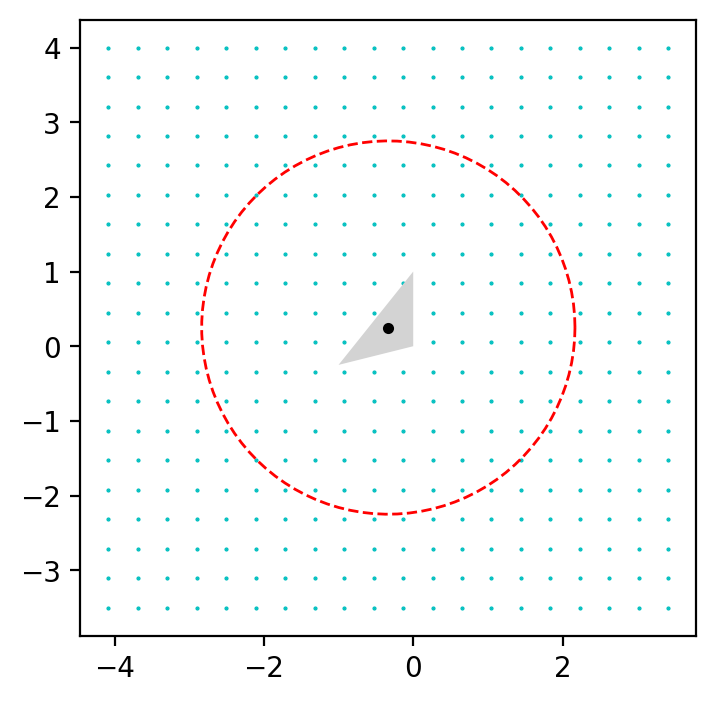

In [3]:
triangle_original = np.array([[0.0, 0.0], [1.0, 0.85], [0.0, 1.0]])
triangle_original = np.array([[0.0, 0.0], [1.0, -0.25], [0.0, 1.0]])  # Good test
triangle_original = np.array([[0.0, 0.0], [-1.0, -0.25], [0.0, 1.0]])  # Good test


# TODO: Find triangle x-coordinate closest to centroid


triangle = np.copy(triangle_original)

# Find triangle centroid
triangle_centroid_x = np.mean(triangle[:, 0])
triangle_centroid_y = np.mean(triangle[:, 1])

# Create an example buffer circle
triangle_vertex_distances_from_centroid = scipy.spatial.distance.cdist(
    np.array([triangle_centroid_x, triangle_centroid_y])[:, None].T, triangle
)
circle_radius_circumscribed = np.max(triangle_vertex_distances_from_centroid)
buffer_scale = 3.0
circle_radius_buffer = buffer_scale * circle_radius_circumscribed
circle_perimeter_convergence_x, circle_perimeter_convergence_y = get_circle_points(
    triangle_centroid_x,
    triangle_centroid_y,
    circle_radius_buffer,
    n_pts=100,
)

# Plot triangle and enclosing circle
plt.figure(figsize=(4, 4))
plt.fill(
    triangle[:, 0],
    triangle[:, 1],
    facecolor="lightgray",
    edgecolor="none",
    linewidth=0.5,
    label="source element",
)
plt.plot(
    circle_perimeter_convergence_x,
    circle_perimeter_convergence_y,
    "--r",
    linewidth=1.0,
    label="convergence boundary",
)
plt.plot(
    triangle_centroid_x, triangle_centroid_y, ".k", label="source centroid", zorder=20
)
plt.gca().set_aspect("equal")

# Find vertex with smallest x-value and translate to the origin
# min_x_vertex_idx =


x_offset = 0.0
y_offset = 0.0
fx = 1.0
fy = 0.0
mu = 1.0
nu = 0.25

# Observation coordinates
min_obs_x = triangle_centroid_x - 1.5 * circle_radius_buffer
max_obs_x = triangle_centroid_x + 1.5 * circle_radius_buffer
min_obs_y = triangle_centroid_y - 1.5 * circle_radius_buffer
max_obs_y = triangle_centroid_y + 1.5 * circle_radius_buffer

n_obs = 20
x_vec = np.linspace(min_obs_x, max_obs_x, n_obs)
y_vec = np.linspace(min_obs_y, max_obs_y, n_obs)
x_grid, y_grid = np.meshgrid(x_vec, y_vec)

plt.plot(x_grid, y_grid, "c.", markersize=1, zorder=0)
plt.show()

#### Fast far-field integration with `quadpy`

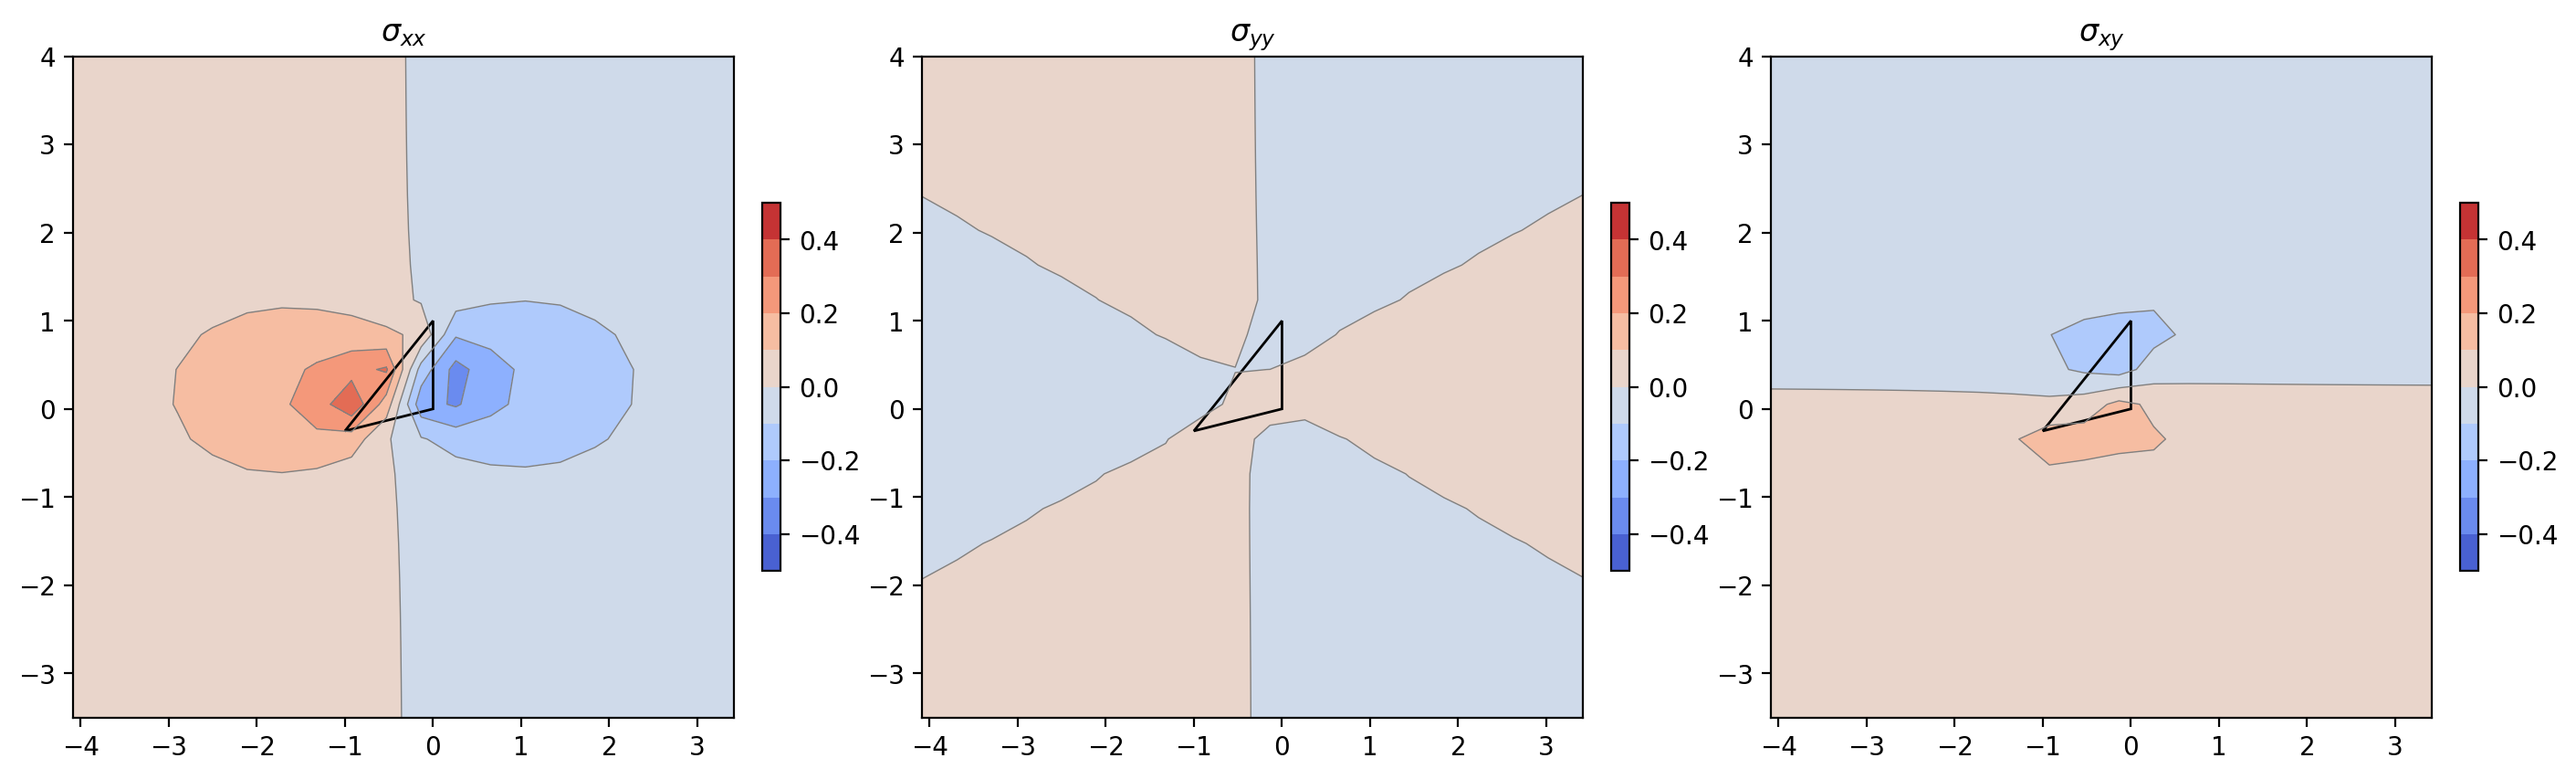

In [4]:
# quadpy integration scheme
scheme = quadpy.t2.get_good_scheme(20)
points_new = np.dot(triangle.T, scheme.points)
n_integration_pts = len(scheme.weights)

# quadpy integration
kelvin_displacements = np.zeros((n_obs**2, 2))
kelvin_stresses = np.zeros((n_obs**2, 3))
for i in range(n_integration_pts):
    x_offset = points_new[0, i]
    y_offset = points_new[1, i]
    kelvin_displacements_local, kelvin_stresses_local = kelvin_point_source(
        x_grid.flatten(), y_grid.flatten(), x_offset, y_offset, fx, fy, mu, nu
    )
    kelvin_displacements += scheme.weights[i] * kelvin_displacements_local
    kelvin_stresses += scheme.weights[i] * kelvin_stresses_local

sxx_quadpy = kelvin_stresses[:, 0]
syy_quadpy = kelvin_stresses[:, 1]
sxy_quadpy = kelvin_stresses[:, 2]


# Stress plotting
plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxx_quadpy, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xx}$",
)
plt.subplot(1, 3, 2)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(syy_quadpy, (n_obs, n_obs)),
    triangle,
    "$\sigma_{yy}$",
)
plt.subplot(1, 3, 3)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxy_quadpy, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xy}$",
)
plt.show()

### `scipy.integrate.dblquad` integration
- The triangle $ABC$ is defined in terms of: $A(0,0)$, $B(L_x,dL_y)$, $C(0,L_y)$

-1.0


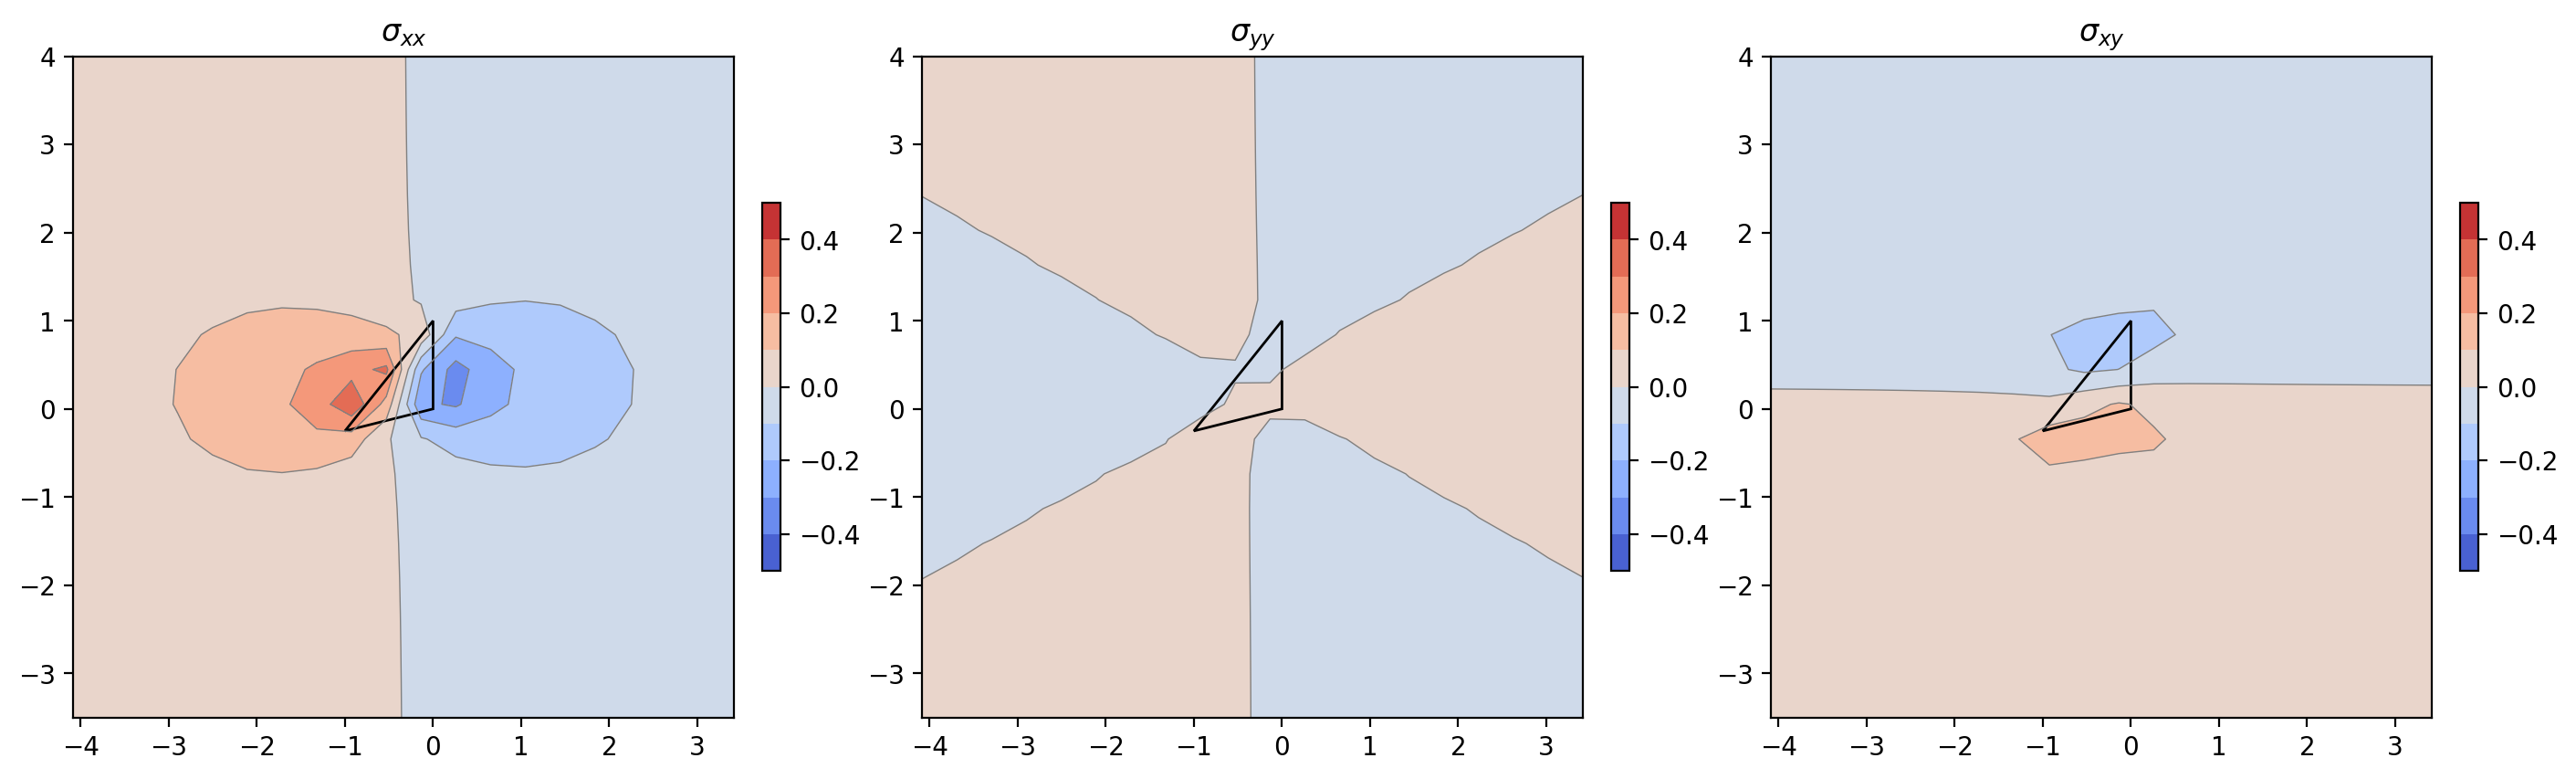

In [5]:
# Define a triangle region in dblquad style
lx = triangle[1, 0]
ly = triangle[2, 1]
dly = triangle[1, 1]

# Flip sign of forcing if we're integrating in the -x direction
if lx < 0:
    fx *= -1
    fy *= -1

print(lx)
triangle_area = get_triangle_area(lx, ly, dly)

# Definition of integration limits over a triangle
ymin = lambda x: dly * x / lx
ymax = lambda x: ly - (ly - dly) * x / lx

sxx_dblquad = np.zeros_like(x_grid).flatten()
syy_dblquad = np.zeros_like(x_grid).flatten()
sxy_dblquad = np.zeros_like(x_grid).flatten()
for i in range(0, x_grid.size):
    # xx stress integration
    f = lambda y, x: kelvin_point_source_stress(
        x_grid.flatten()[i], y_grid.flatten()[i], x, y, fx, fy, mu, nu
    )[0]
    # sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
    sxx_dblquad[i] = sol / triangle_area

    # yy stress integration
    f = lambda y, x: kelvin_point_source_stress(
        x_grid.flatten()[i], y_grid.flatten()[i], x, y, fx, fy, mu, nu
    )[1]
    # sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
    syy_dblquad[i] = sol / triangle_area

    # xy stress integration
    f = lambda y, x: kelvin_point_source_stress(
        x_grid.flatten()[i], y_grid.flatten()[i], x, y, fx, fy, mu, nu
    )[2]
    # sol, err = scipy.integrate.dblquad(f, 0, 1, ymin, ymax, epsabs=1e-3)
    sol, err = scipy.integrate.dblquad(f, 0, lx, ymin, ymax, epsabs=1e-3)
    sxy_dblquad[i] = sol / triangle_area


plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxx_dblquad, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xx}$",
)

plt.subplot(1, 3, 2)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(syy_dblquad, (n_obs, n_obs)),
    triangle,
    "$\sigma_{yy}$",
)

plt.subplot(1, 3, 3)
plot_stresses(
    x_grid,
    y_grid,
    np.reshape(sxy_dblquad, (n_obs, n_obs)),
    triangle,
    "$\sigma_{xy}$",
)
plt.show()

### Plot residual stresses

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_76547/1550270593.py:5: RuntimeWarning: divide by zero encountered in log10
  sxx_residual = np.log10(np.abs(sxx_residual))
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_76547/1550270593.py:10: RuntimeWarning: divide by zero encountered in log10
  syy_residual = np.log10(np.abs(syy_residual))
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_76547/1550270593.py:15: RuntimeWarning: divide by zero encountered in log10
  sxy_residual = np.log10(np.abs(sxy_residual))


(-3.5, 4.0)

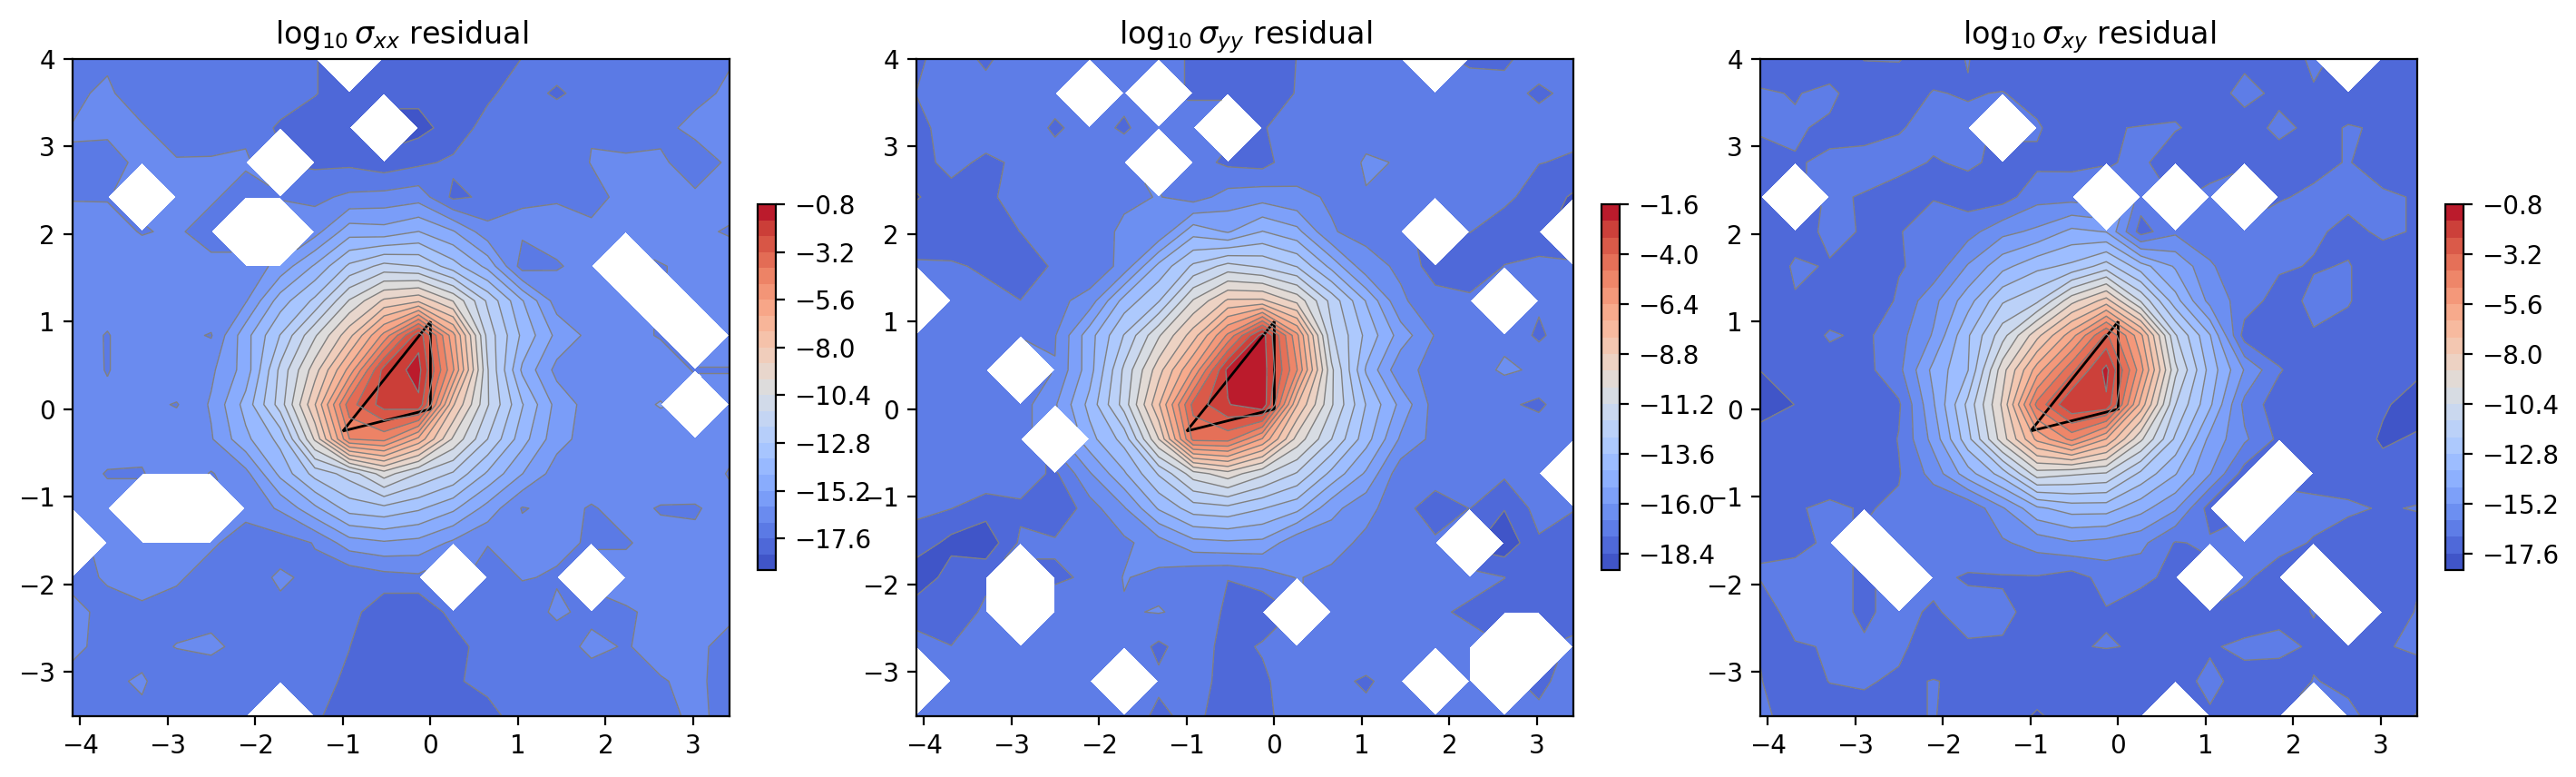

In [6]:
LEVELS_RESIDUAL = 21
sxx_residual = np.reshape(sxx_dblquad, (n_obs, n_obs)) - np.reshape(
    sxx_quadpy, (n_obs, n_obs)
)
sxx_residual = np.log10(np.abs(sxx_residual))

syy_residual = np.reshape(syy_dblquad, (n_obs, n_obs)) - np.reshape(
    syy_quadpy, (n_obs, n_obs)
)
syy_residual = np.log10(np.abs(syy_residual))

sxy_residual = np.reshape(sxy_dblquad, (n_obs, n_obs)) - np.reshape(
    sxy_quadpy, (n_obs, n_obs)
)
sxy_residual = np.log10(np.abs(sxy_residual))

plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
plt.contourf(
    x_grid,
    y_grid,
    sxx_residual,
    cmap="coolwarm",
    levels=LEVELS_RESIDUAL,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_grid,
    y_grid,
    sxx_residual,
    colors="gray",
    linestyles="solid",
    linewidths=LINEWIDTH,
    levels=LEVELS_RESIDUAL,
)
plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
plt.title("$\log_{10}\sigma_{xx}$ residual")
plt.gca().set_aspect("equal")
plt.xlim([np.min(x_grid), np.max(x_grid)])
plt.ylim([np.min(y_grid), np.max(y_grid)])


plt.subplot(1, 3, 2)
plt.contourf(
    x_grid,
    y_grid,
    syy_residual,
    cmap="coolwarm",
    levels=LEVELS_RESIDUAL,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_grid,
    y_grid,
    syy_residual,
    colors="gray",
    linestyles="solid",
    linewidths=LINEWIDTH,
    levels=LEVELS_RESIDUAL,
)
plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
plt.title("$\log_{10}\sigma_{yy}$ residual")
plt.gca().set_aspect("equal")
plt.xlim([np.min(x_grid), np.max(x_grid)])
plt.ylim([np.min(y_grid), np.max(y_grid)])


plt.subplot(1, 3, 3)
plt.contourf(
    x_grid,
    y_grid,
    sxy_residual,
    cmap="coolwarm",
    levels=LEVELS_RESIDUAL,
)
plt.colorbar(fraction=0.026, pad=0.04, extend="both")
plt.contour(
    x_grid,
    y_grid,
    sxy_residual,
    colors="gray",
    linestyles="solid",
    linewidths=LINEWIDTH,
    levels=LEVELS_RESIDUAL,
)
plt.fill(triangle[:, 0], triangle[:, 1], facecolor="None", edgecolor="k")
plt.title("$\log_{10}\sigma_{xy}$ residual")
plt.gca().set_aspect("equal")
plt.xlim([np.min(x_grid), np.max(x_grid)])
plt.ylim([np.min(y_grid), np.max(y_grid)])

### Calculate residual as a function of distance from centroid

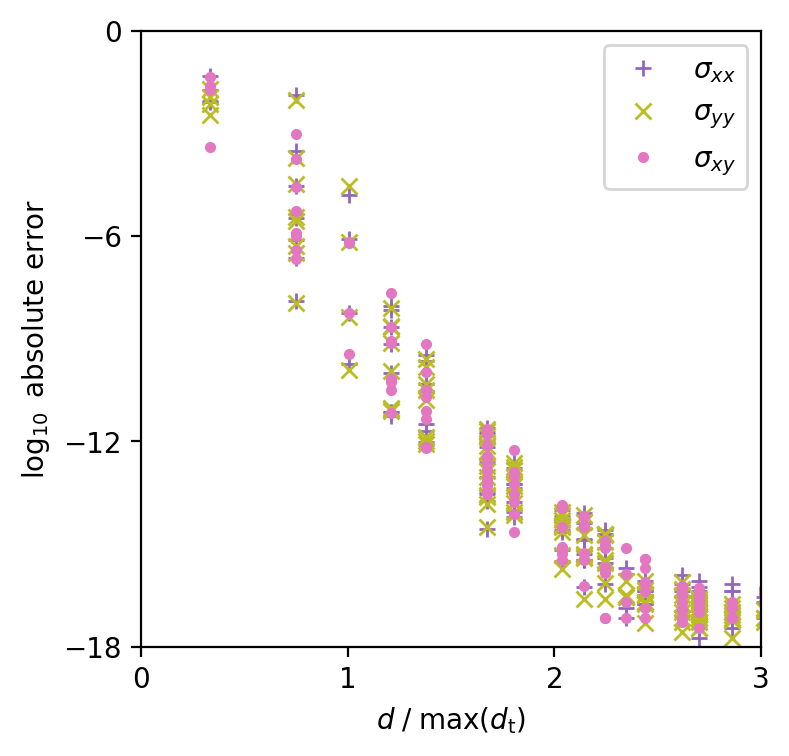

In [7]:
obs_distances_from_centroid = scipy.spatial.distance.cdist(
    np.array([triangle_centroid_x, triangle_centroid_y])[:, None].T,
    np.array([x_grid.flatten(), y_grid.flatten()]).T,
)

plt.figure(figsize=(4, 4))
plt.plot(
    obs_distances_from_centroid.flatten() / circle_radius_circumscribed,
    sxx_residual.flatten(),
    "+",
    color="tab:purple",
    label="$\sigma_{xx}$",
)
plt.plot(
    obs_distances_from_centroid.flatten() / circle_radius_circumscribed,
    syy_residual.flatten(),
    "x",
    color="tab:olive",
    label="$\sigma_{yy}$",
)
plt.plot(
    obs_distances_from_centroid.flatten() / circle_radius_circumscribed,
    sxy_residual.flatten(),
    ".",
    color="tab:pink",
    label="$\sigma_{xy}$",
)
plt.xlim([0, 3])
plt.xticks([0, 1, 2, 3])
plt.xlabel("$d \; / \; \mathrm{max}(d_\mathrm{t})$")
plt.ylim([-18, 0])
plt.yticks([-18, -12, -6, 0])
plt.ylabel("$\log_{10}$ absolute error")
plt.legend()
plt.savefig("distance_residual.pdf", bbox_inches="tight")
plt.savefig("distance_residual.png", dpi=500, bbox_inches="tight")
plt.show()

In [8]:
# DONE: Find triangle centroid
# DONE: Generate synthetic observation points based on triangle vertices
# TODO: Translate and rotated triangle to get the correct edge alignment
# TODO: Integration in translated and rotated space
# TODO: Project stresses and displacements back to unrotated space
# DONE: Buffer rule

already a vertical line
reording vertices


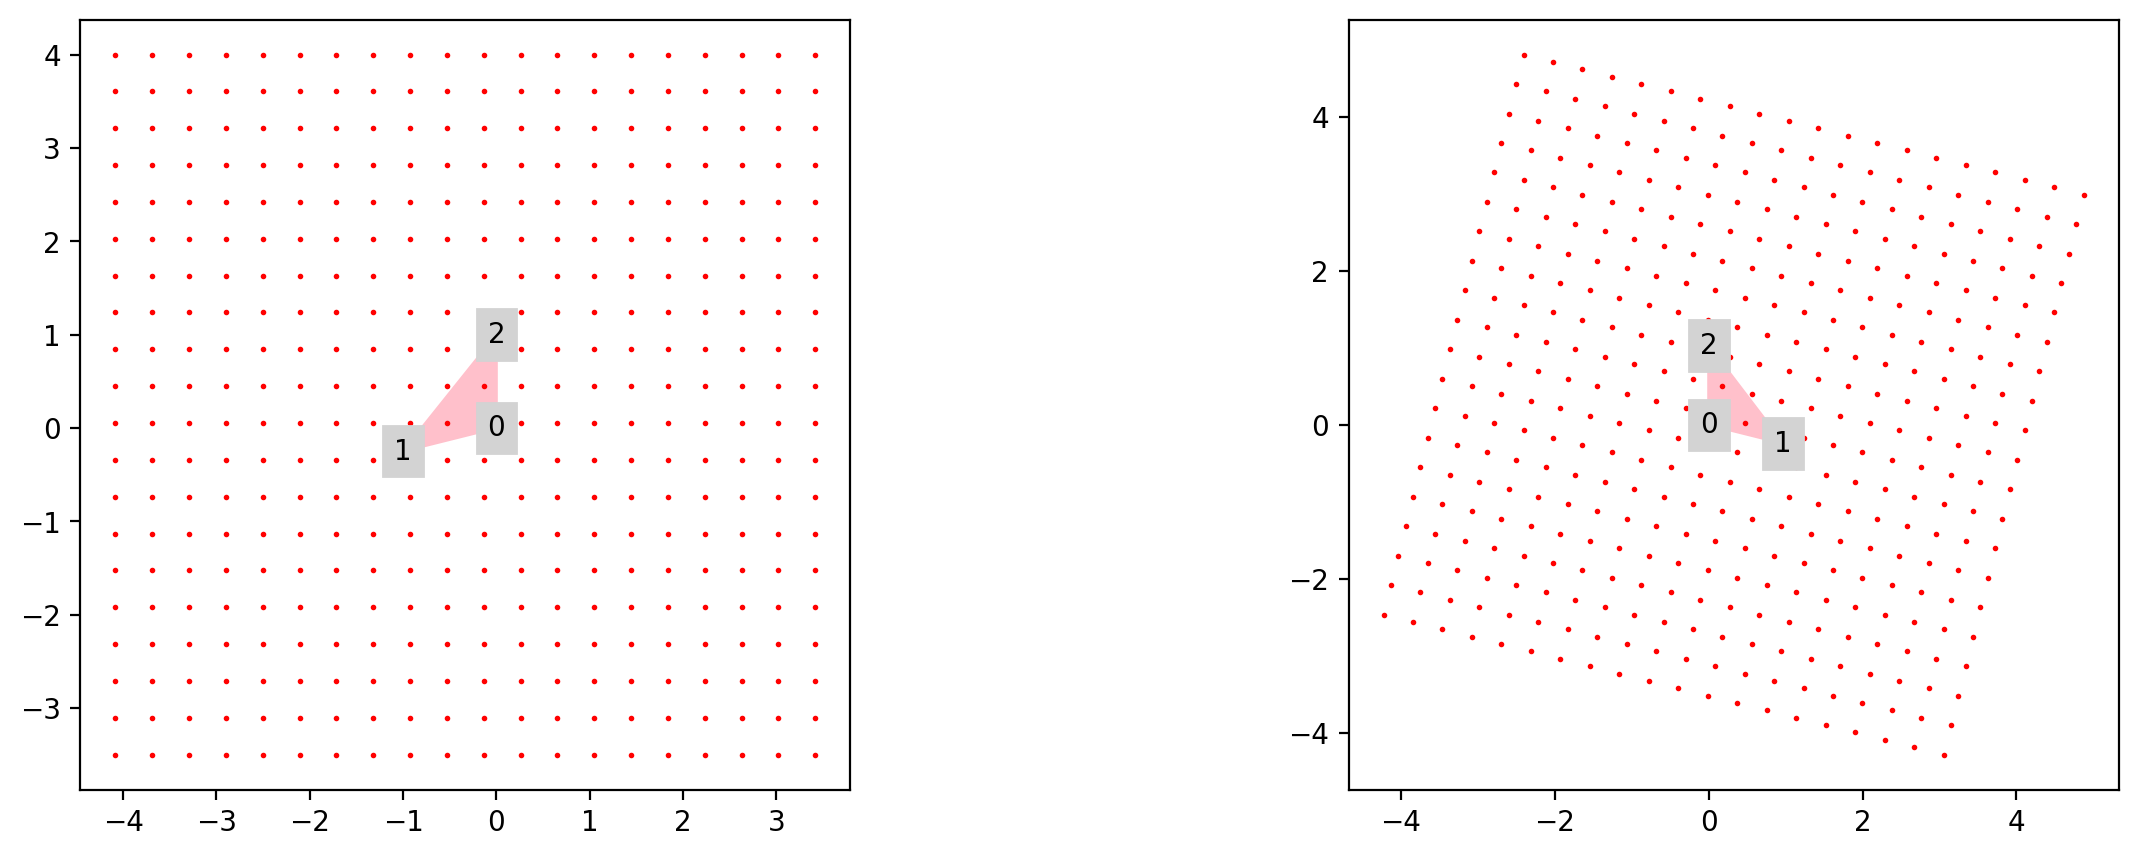

In [55]:
def get_transformed_coordinates(vertices, obs_x, obs_y):
    # Translate the triangle so that the first vertex is at the origin
    translated_vertices = vertices - np.array(vertices[0])
    translated_obs_x = obs_x - vertices[0, 0]
    translated_obs_y = obs_y - vertices[0, 1]

    # Determine the angle to rotate the second vertex to align with the y-axis
    second_vertex = translated_vertices[1]
    angle = np.arctan2(second_vertex[0], second_vertex[1])

    # Rotation matrix to align the second vertex along the positive y-axis
    rotation_matrix = np.array(
        [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
    )
    rotated_vertices = np.dot(translated_vertices, rotation_matrix.T)
    rotated_obs = np.dot(
        np.array([translated_obs_x, translated_obs_y]).T, rotation_matrix.T
    )

    # If neccesary reorder vertices for integration
    if rotated_vertices[1, 0] != 0.0:
        print("reording vertices")
        rotated_vertices[[1, 2], :] = rotated_vertices[[2, 1], :]

    return rotated_vertices, rotated_obs[:, 0], rotated_obs[:, 1]


# Function to plot the triangle
def plot_triangle(vertices):
    plt.fill(vertices[:, 0], vertices[:, 1], color="pink")
    plt.text(
        vertices[0, 0],
        vertices[0, 1],
        "0",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[1, 0],
        vertices[1, 1],
        "1",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.text(
        vertices[2, 0],
        vertices[2, 1],
        "2",
        va="center",
        ha="center",
        backgroundcolor="lightgray",
    )
    plt.gca().set_aspect("equal", adjustable="box")


# Translate and rotate the triangle
triangle_transformed, obs_x_transformed, obs_y_transformed = (
    get_transformed_coordinates(triangle, x_grid.flatten(), y_grid.flatten())
)

# Plot the original triangle
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_triangle(triangle)
plt.plot(x_grid.flatten(), y_grid.flatten(), "r.", markersize=2)

plt.subplot(1, 2, 2)
plot_triangle(triangle_transformed)
plt.plot(obs_x_transformed, obs_y_transformed, "r.", markersize=2)
plt.show()